# Week 1: Linear Regression 1
Include concepts such as linear regression with polynomial terms, interaction terms, multicolllinearity, variance inflation factor and regression, and categorical and continuous features.

In [1]:
# Standard Libraries
import os
import time
import math
import io
import zipfile
import requests
import kagglehub
from urllib.parse import urlparse
from itertools import chain, combinations
from collections import Counter
import re
from IPython.display import display
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import itertools
from scipy.stats import spearmanr

# Data Science Libraries
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as mticker
import seaborn as sns

# Scikit-learn (Machine Learning)
from sklearn.model_selection import (
    train_test_split, 
    cross_val_score, 
    GridSearchCV, 
    RandomizedSearchCV, 
    RepeatedKFold,
    RepeatedStratifiedKFold
)
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, accuracy_score, r2_score
from sklearn.feature_selection import SequentialFeatureSelector, f_regression, SelectKBest
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LogisticRegression
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn import decomposition
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import make_pipeline

# Progress Tracking
from tqdm import tqdm

# Language Processing
from textblob import TextBlob
from datetime import datetime, timedelta
import string

# globals
random_state = 42

In [2]:
def run_linear_regression(df, target_label, test_size=0.2, remove_outliers=True, lower=0.01, upper=0.99):
    
    # Error handling
    if not isinstance(df, pd.DataFrame):
        raise TypeError("Input 'df' must be a pandas DataFrame.")

    if not isinstance(target_label, str):
        raise TypeError("Input 'target_label' must be a string (column name).")

    if target_label not in df.columns:
        raise ValueError(f"'{target_label}' not found in DataFrame columns.")
    
    # Copy dataframe
    data = df.copy()

    # Remove outliers if requested
    if remove_outliers:
        upper_limits = data.quantile(upper)
        lower_limits = data.quantile(lower)

        # Keep only rows within percentile range
        data = data[~((data > upper_limits) | (data < lower_limits)).any(axis=1)]

    # Separate features (X) and target (y)
    X = add_constant(data.drop(columns=[target_label]))
    y = data[target_label]
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    # Create model
    model = LinearRegression()

    # Pipeline with scaler
    pipeline = make_pipeline(StandardScaler(), model)

    # Fit and predict
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    # R-Squared Values
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"R Squared: {r2:.4f}")
    print(f"RMSE: {rmse:.4f}")

    # Plot predicted vs. actual
    plt.scatter(y_test, y_pred, alpha=0.7)
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title("Predicted vs Actual")
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.show()


In [3]:
def analyze_feature_relationships(df, target_label, corr_threshold=0.5, interaction_threshold=0.3):
    
    # Error handling
    if not isinstance(df, pd.DataFrame):
        raise TypeError("Input 'df' must be a pandas DataFrame.")

    if not isinstance(target_label, str):
        raise TypeError("Input 'target_label' must be a string (column name).")

    if target_label not in df.columns:
        raise ValueError(f"'{target_label}' not found in DataFrame columns.")

    # Copy dataframe
    data = df.copy()
    
    # Separate features (X) and target (y)
    X = df.drop(columns=[target_label])
    y = df[target_label]
    
    # Calculate correlation matrix
    corr_matrix = X.corr()
    target_corr = X.corrwith(y).sort_values(key=abs, ascending=False)

    # Print top correlations with target variable
    print("\nTop 10 Correlations:")
    
    # Display results
    pd.set_option("display.max_rows", None)
    display(target_corr.head(10))

    # Extract high correlation features
    high_corr_features = target_corr[abs(target_corr) >= corr_threshold].index.tolist()

    # Evaulate interaction potential
    potential_interactions = []
    for f1, f2 in itertools.combinations(high_corr_features, 2):
        inter_corr = abs(corr_matrix.loc[f1, f2])
        if inter_corr < interaction_threshold:
            potential_interactions.append((f1, f2))

    if potential_interactions:
        print("\nPotential Interactions Terms:\n")
        for f1, f2 in potential_interactions:
            print(f'{f1} and {f2}')

    else:
        print("\nPotential Interactions Terms:\n")
        print("No strong candidates for interaction terms were found.")

    # Explore potential polynomial relationship terms
    potential_poly = []
    for f in high_corr_features:
        rho, _ = spearmanr(X[f], y)
        if abs(rho) - abs(target_corr[f]) > 0.1:
            potential_poly.append(f)

    if potential_poly:
        print("\nPotential Polynomial Terms:\n")
        for f in potential_poly:
            print(f)

    else:
        print("\nPotential Polynomial Terms:\n")
        print("No strong candidates for polynomial terms were found.")

## Dataset 1: Web Page Phishing Dectection

In [4]:
# Load cleaned data
cleaned_webpage = pd.read_csv('cleaned_webpage.csv')
cleaned_webpage.head()

,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,nb_eq,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,legitimate
0,37,19,0,3,0,0,0,0,0,0,...,0,1,0,45,0,0,1,1,4,1
1,77,23,1,1,0,0,0,0,0,0,...,1,0,0,77,5767,0,0,1,2,0
2,126,50,1,4,1,0,1,2,0,3,...,1,0,0,14,4004,5828815,0,1,0,0
3,18,11,0,2,0,0,0,0,0,0,...,1,0,0,62,0,107721,0,0,3,1
4,55,15,0,2,2,0,0,0,0,0,...,0,1,0,224,8175,8725,0,0,6,1


In [5]:
# Drop target variable
wp_features = cleaned_webpage.drop(columns=['legitimate'])

# Drop constant columns
wp_features_cleaned = wp_features.loc[:, wp_features.nunique() > 1]

# Scale features
scaler = StandardScaler()
webpage_features = pd.DataFrame(scaler.fit_transform(wp_features_cleaned), columns=wp_features_cleaned.columns)

# Check for multicollinearity
webpage_features_const = add_constant(webpage_features)

# Compute VIF for each feature
vif = pd.DataFrame()
vif["Feature"] = webpage_features_const.columns
vif["Variance Inflation Factor"] = [variance_inflation_factor(webpage_features_const.values, i) for i in range(webpage_features_const.shape[1])]

# Sort results
vif = vif.sort_values(by="Variance Inflation Factor", ascending=False).reset_index(drop=True)

# Display results
vif.head(10)

,Feature,Variance Inflation Factor
0,longest_word_path,107.802897
1,longest_words_raw,101.000951
2,length_words_raw,68.362153
3,avg_word_host,49.869906
4,avg_words_raw,23.084318
5,longest_word_host,23.075606
6,shortest_word_host,19.784253
7,avg_word_path,16.846360
8,nb_eq,13.222512
9,nb_and,11.993586


In [6]:
analyze_feature_relationships(wp_features_cleaned, 'page_rank', corr_threshold=0.3, interaction_threshold=0.3)


Top 10 Correlations:


domain_age                    0.589620
domain_in_brand               0.514714
google_index                 -0.389887
domain_registration_length    0.345752
domain_in_title              -0.330810
https_token                  -0.264065
tld_in_subdomain             -0.244401
nb_hyperlinks                 0.223463
ip                           -0.218968
avg_word_host                -0.215858
dtype: float64


Potential Interactions Terms:

domain_age and google_index
domain_age and domain_registration_length
domain_age and domain_in_title
domain_in_brand and google_index
domain_in_brand and domain_registration_length
domain_in_brand and domain_in_title
google_index and domain_registration_length
google_index and domain_in_title
domain_registration_length and domain_in_title

Potential Polynomial Terms:

No strong candidates for polynomial terms were found.


R Squared: 0.6700
RMSE: 1.4220


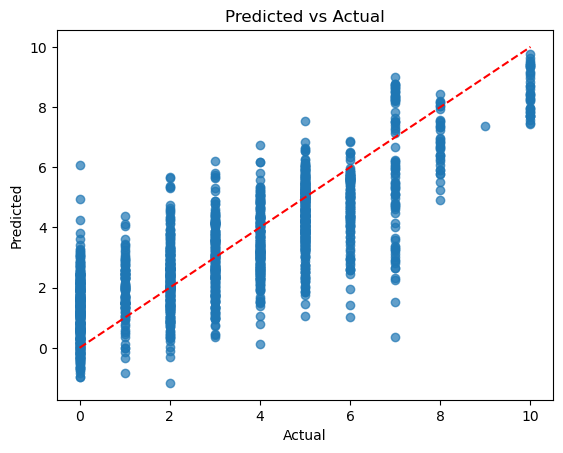

In [7]:
# Run model
run_linear_regression(wp_features_cleaned, 'page_rank', test_size=0.2)

In [8]:
# Add top interaction term (domain_age*google_index)
webpage_features_interaction1 = wp_features_cleaned.copy()
webpage_features_interaction1['domain_age*google_index'] = webpage_features_interaction1['domain_age'] * webpage_features_interaction1['google_index']

R Squared: 0.6498
RMSE: 1.4461


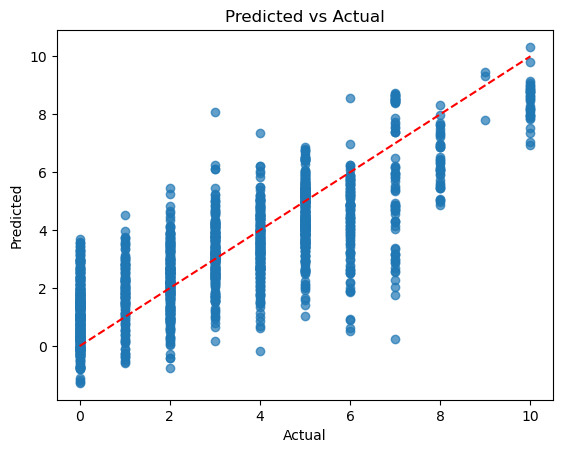

In [9]:
run_linear_regression(webpage_features_interaction1, 'page_rank', test_size=0.2)

In [10]:
# Add top three interaction terms
webpage_features_interactions = wp_features_cleaned.copy()
webpage_features_interactions['domain_age*google_index'] = webpage_features_interactions['domain_age'] * webpage_features_interactions['google_index']
webpage_features_interactions['domain_age*domain_registration_length'] = webpage_features_interactions['domain_age'] * webpage_features_interactions['domain_registration_length']
webpage_features_interactions['domain_age*domain_in_title'] = webpage_features_interactions['domain_age'] * webpage_features_interactions['domain_in_title']

R Squared: 0.6557
RMSE: 1.4044


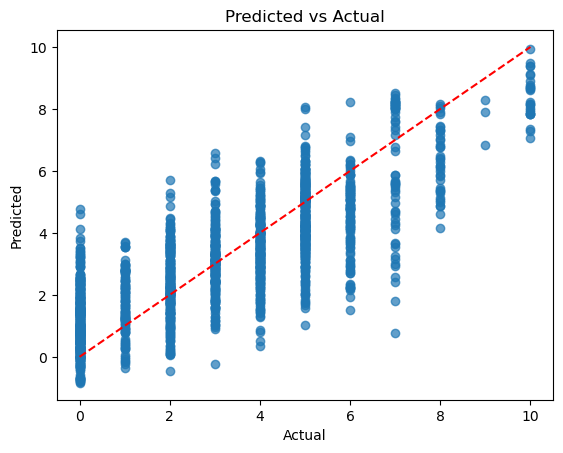

In [11]:
run_linear_regression(webpage_features_interactions, 'page_rank', test_size=0.2)

## Dataset 2: Phishing Email Detection

In [12]:
# Load cleaned data
cleaned_email = pd.read_csv('cleaned_phishing_email.csv')
cleaned_email.head()

,polarity,subjectivity,unique_words,char_count,word_count,uppercase_ratio,symbol_ratio,kw_urgent,kw_verify,kw_account,kw_click,kw_suspend,kw_update,kw_login,kw_confirm,currency_symbol_count,phone_number_count,Safe Email
0,0.201493,0.514213,110.0,1030.0,230.0,0.000000,0.059223,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.009375,0.084375,53.0,479.0,91.0,0.000000,0.037578,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.091540,0.515783,102.0,1245.0,305.0,0.000000,0.077108,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.260069,0.690278,73.0,688.0,96.0,0.056686,0.162791,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0
4,0.152579,0.505258,60.0,441.0,91.0,0.000000,0.061224,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [13]:
# Drop target variable
em_features = cleaned_email.drop(columns=['Safe Email'])

# Drop constant columns
em_features_cleaned = em_features.loc[:, em_features.nunique() > 1]

# Scale features
scaler = StandardScaler()
email_features = pd.DataFrame(scaler.fit_transform(em_features_cleaned), columns=em_features_cleaned.columns)

# Check for multicollinearity
email_features_const = add_constant(email_features)

# Compute VIF for each feature
vif_email = pd.DataFrame()
vif_email["Feature"] = email_features_const.columns
vif_email["Variance Inflation Factor"] = [variance_inflation_factor(email_features_const.values, i) for i in range(email_features_const.shape[1])]

# Sort results
vif_email = vif_email.sort_values(by="Variance Inflation Factor", ascending=False).reset_index(drop=True)

# Display results
pd.set_option("display.max_rows", None)
display(vif_email.head(10))

,Feature,Variance Inflation Factor
0,word_count,8848.161936
1,char_count,8375.291167
2,phone_number_count,491.142235
3,currency_symbol_count,100.098012
4,unique_words,15.480988
5,kw_account,1.200991
6,uppercase_ratio,1.190301
7,kw_click,1.093734
8,symbol_ratio,1.083283
9,kw_suspend,1.056432


In [14]:
analyze_feature_relationships(em_features_cleaned, 'polarity', corr_threshold=0.05, interaction_threshold=0.3)


Top 10 Correlations:


subjectivity       0.170243
kw_click           0.094642
uppercase_ratio    0.077426
symbol_ratio       0.033390
kw_confirm        -0.015080
kw_account        -0.013924
kw_update          0.011505
kw_suspend        -0.011257
kw_urgent         -0.007595
kw_login          -0.006146
dtype: float64


Potential Interactions Terms:

subjectivity and kw_click
subjectivity and uppercase_ratio
kw_click and uppercase_ratio

Potential Polynomial Terms:

No strong candidates for polynomial terms were found.


R Squared: 0.0851
RMSE: 0.1353


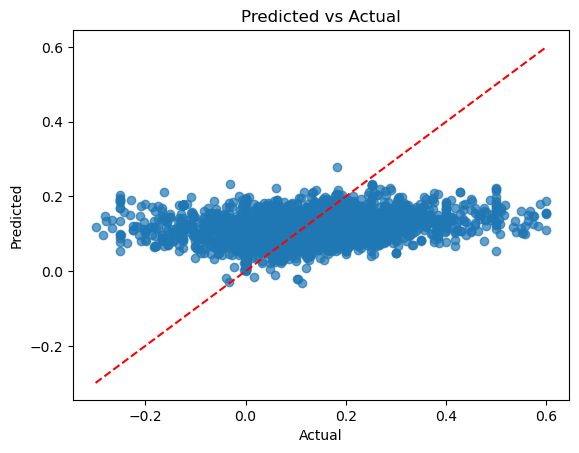

In [15]:
run_linear_regression(em_features_cleaned, 'polarity', test_size=0.2)

In [16]:
# Add top interaction term (subjectivity*kw_click)
em_features_interaction1 = em_features_cleaned.copy()
em_features_interaction1['subjectivity*kw_click'] = em_features_interaction1['subjectivity'] * em_features_interaction1['kw_click']

R Squared: 0.0809
RMSE: 0.1362


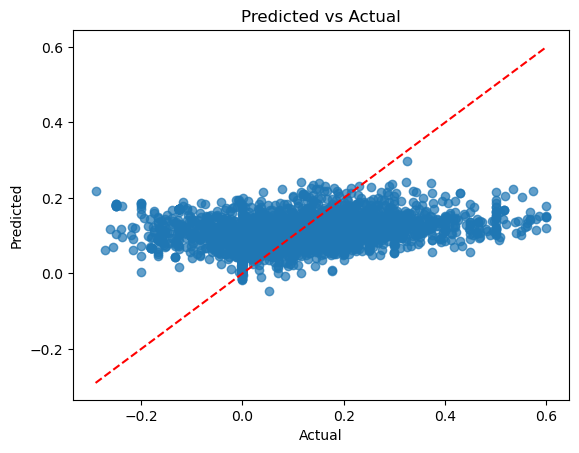

In [17]:
run_linear_regression(em_features_interaction1, 'polarity', test_size=0.2)

In [18]:
# Add top three interaction terms
em_features_interactions = em_features_cleaned.copy()
em_features_interactions['subjectivity*kw_click'] = em_features_interactions['subjectivity'] * em_features_interactions['kw_click']
em_features_interactions['subjectivity*uppercase_ratio'] = em_features_interactions['subjectivity'] * em_features_interactions['uppercase_ratio']
em_features_interactions['uppercase_ratio*kw_click'] = em_features_interactions['uppercase_ratio'] * em_features_interactions['kw_click']

R Squared: 0.0946
RMSE: 0.1347


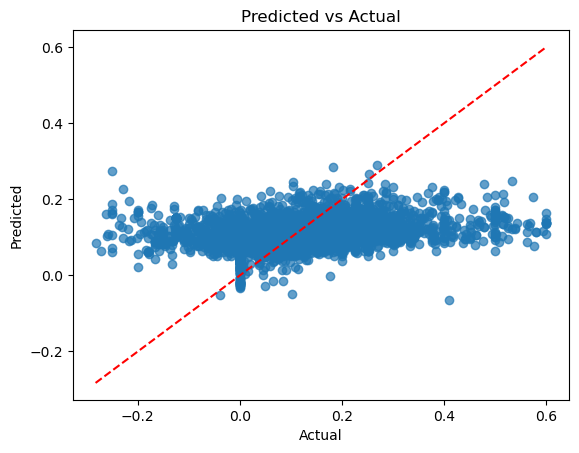

In [19]:
run_linear_regression(em_features_interactions, 'polarity', test_size=0.2)

## Dataset 3: Credit Card Transactions Fraud Detection Dataset

In [20]:
# Load cleaned data
cleaned_credit_card = pd.read_csv('cleaned_credit_card.csv')
cleaned_credit_card.head()

,category,amt,gender,city,state,lat,long,city_pop,job,unix_time,merch_lat,merch_long,age,max_repeats,is_fraud
0,0,2.86,0,0,0,33.9659,-80.9355,333497,0,1371816865,33.986391,-81.200714,57,3,0
1,0,29.84,1,1,1,40.3207,-110.4360,302,1,1371816873,39.450498,-109.960431,35,4,0
2,1,41.28,1,2,2,40.6729,-73.5365,34496,2,1371816893,40.495810,-74.196111,54,4,0
3,2,60.05,0,3,3,28.5697,-80.8191,54767,3,1371816915,28.812398,-80.883061,38,4,0
4,3,3.19,0,4,4,44.2529,-85.0170,1126,4,1371816917,44.959148,-85.884734,70,3,0


In [21]:
# Drop target variable
cc_features = cleaned_credit_card.drop(columns=['is_fraud'])

# Drop constant columns
cc_features_cleaned = cc_features.loc[:, cc_features.nunique() > 1]

# Scale features
scaler = StandardScaler()
credit_card_features = pd.DataFrame(scaler.fit_transform(cc_features_cleaned), columns=cc_features_cleaned.columns)

# Check for multicollinearity
credit_card_features_const = add_constant(credit_card_features)

# Compute VIF for each feature
vif_cc = pd.DataFrame()
vif_cc["Feature"] = credit_card_features_const.columns
vif_cc["Variance Inflation Factor"] = [variance_inflation_factor(credit_card_features_const.values, i) for i in range(credit_card_features_const.shape[1])]

# Sort results
vif_cc = vif_cc.sort_values(by="Variance Inflation Factor", ascending=False).reset_index(drop=True)

# Display results
print("Top 10 VIFs")
display(vif_cc.head(10))

Top 10 VIFs


,Feature,Variance Inflation Factor
0,long,567.382787
1,merch_long,567.354447
2,lat,78.252504
3,merch_lat,78.153534
4,city,1.657823
5,job,1.564813
6,state,1.115299
7,age,1.075607
8,city_pop,1.051544
9,max_repeats,1.015229


In [22]:
analyze_feature_relationships(cc_features_cleaned, 'city_pop', corr_threshold=0.05, interaction_threshold=0.3)


Top 10 Correlations:


lat          -0.154816
merch_lat    -0.153863
city         -0.127047
state        -0.093869
age          -0.092916
long         -0.052359
merch_long   -0.052329
job          -0.044188
gender        0.028862
category     -0.005827
dtype: float64


Potential Interactions Terms:

lat and city
lat and state
lat and age
lat and long
lat and merch_long
merch_lat and city
merch_lat and state
merch_lat and age
merch_lat and long
merch_lat and merch_long
city and state
city and age
city and long
city and merch_long
state and age
state and long
state and merch_long
age and long
age and merch_long

Potential Polynomial Terms:

lat
merch_lat


R Squared: 0.0360
RMSE: 218037.3763


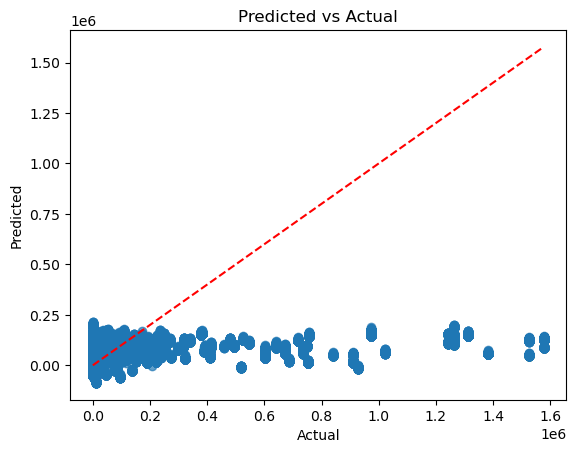

In [23]:
run_linear_regression(cc_features_cleaned, 'city_pop', test_size=0.2)

In [24]:
# Add interaction term (lat*city)
cc_features_interaction1 = cc_features_cleaned.copy()
cc_features_interaction1['lat*city'] = cc_features_interaction1['lat'] * cc_features_interaction1['city']

R Squared: 0.0382
RMSE: 216564.9022


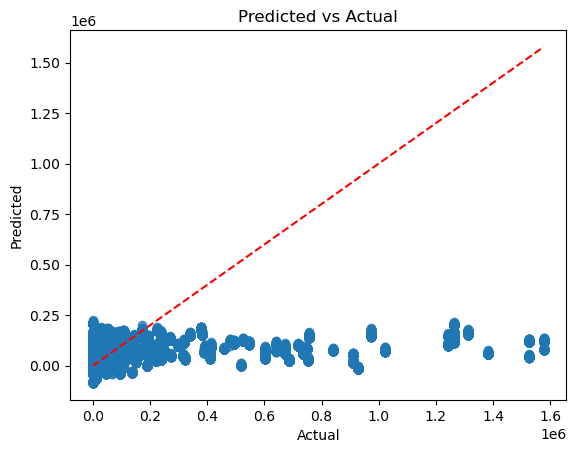

In [25]:
run_linear_regression(cc_features_interaction1, 'city_pop', test_size=0.2)

In [26]:
# Add top three interaction terms
cc_features_interactions = cc_features_cleaned.copy()
cc_features_interactions['lat*city'] = cc_features_interactions['lat'] * cc_features_interactions['city']
cc_features_interactions['lat*state'] = cc_features_interactions['lat'] * cc_features_interactions['state']
cc_features_interactions['lat*age'] = cc_features_interactions['lat'] * cc_features_interactions['age']

R Squared: 0.0411
RMSE: 218239.6429


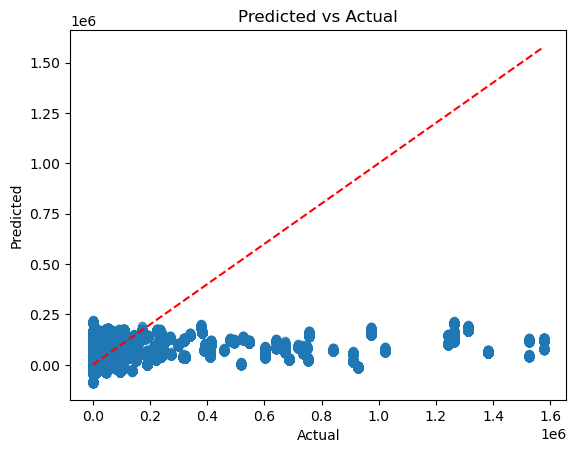

In [27]:
run_linear_regression(cc_features_interactions, 'city_pop', test_size=0.2)

In [28]:
# Add polynomial term
cc_features_poly = cc_features_cleaned.copy()
cc_features_poly['lat*lat'] = cc_features_poly['lat'] * cc_features_poly['lat']

R Squared: 0.0379
RMSE: 217819.8191


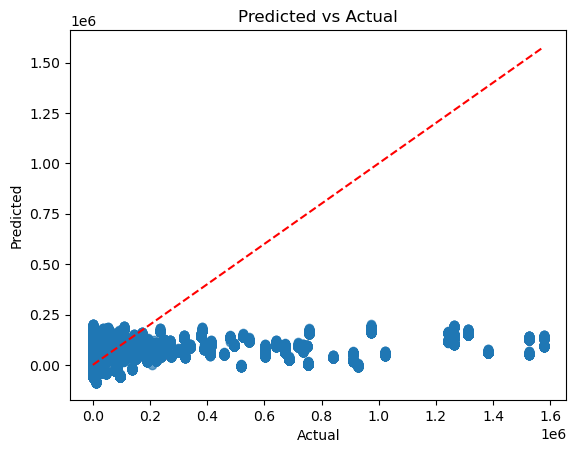

In [29]:
run_linear_regression(cc_features_poly, 'city_pop', test_size=0.2)

In [30]:
# Everything together
cc_features_all = cc_features_cleaned.copy()
cc_features_all['lat*city'] = cc_features_all['lat'] * cc_features_all['city']
cc_features_all['lat*state'] = cc_features_all['lat'] * cc_features_all['state']
cc_features_all['lat*age'] = cc_features_all['lat'] * cc_features_all['age']
cc_features_all['lat*lat'] = cc_features_all['lat'] * cc_features_all['lat']

R Squared: 0.0422
RMSE: 218109.3482


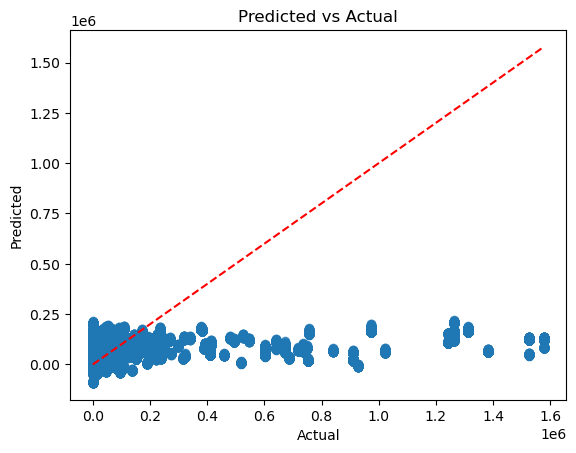

In [31]:
run_linear_regression(cc_features_all, 'city_pop', test_size=0.2)